# Old Babylonian Lists of Trees and Wooden Objects

## Introductory text needs updating
This notebook will use data scraped from [DCCLT](http://oracc.org/dcclt) with the notebooks [Save ORACC HTML files](https://github.com/niekveldhuis/Digital-Assyriology/blob/master/Scrape-Oracc/Save%20Oracc%20HTML%20files.ipynb) and [Scrape Oracc](https://github.com/niekveldhuis/Digital-Assyriology/blob/master/Scrape-Oracc/Scrape%20Oracc.ipynb), using the input file [ob_lists_wood.txt](https://github.com/ErinBecker/digital-humanities-phylogenetics/blob/master/data/text_ids/ob_lists_wood.txt). The input file lists all the Text IDs of Old Babylonian lists of trees and wooden objects currently in DCCLT, as well as the composite text of the Nippur version. Text IDs consist of a P plus a six-digit number (commonly referred to as P-number) that is recognized by [ORACC](http://oracc.org) and by [CDLI](http://cdli.ucla.edu) and that has become the de-facto standard in Assyriology. [CDLI](http://cdli.ucla.edu) provides metadata (provenience, period, publication, museum number, etc) for each text.  Composite text IDs consist of a Q plus a six-digit number.

The raw data are placed in the directory [data/raw](https://github.com/ErinBecker/digital-humanities-phylogenetics/tree/master/data/raw). Each text has a separate file named dcclt_P######.txt (or dcclt_Q######.txt). These are comma-separated files with the fields id_text, text_name, l_no, text. 

| field         | description                     |
|-----------	|------------------------------------------------------------------------------------------------------------------------------------------------------	|
| id_line   	| allows creation of a link to the online edition in [DCCLT](http://oracc.org/dcclt) and/or to the images and metadata in [CDLI](http://cdli.ucla.edu) 	|
| label 	| line number: obverse/reverse, column number, line number (e.g. o ii 16')                                                          	|
| lemma      	| Sumerian words in lemmatized form (e.g. lugal[king]N)                                                                                  	|
| base      	| Sumerian words in original spelling, but without morphological prefixes or suffixes   |
| extent | (for missing data): how many lines or columns (restricted vocabulary) |
| scope | (for missing data): line, column, face, or surface |

This data presents a couple of discrete problems with respect to handling missing information. There were several types of missing information, which are handled in different ways.  

| type         | how represented                     |
|-----------	|------------------------------------------------------------------------------------------------------------------------------------------------------	|
| words with unknown translation| eg. siki-siki[NA]NA |
| illegible words | x[NA]NA |
| known number of missing lines 	| |
| unknown number of missing lines	| 
  


In [1]:
import pandas as pd
import numpy as np
import re

# Open File
Open file `obwood.csv` and create a Dataframe in Pandas. 

In [2]:
file = '../data/ob_lists_wood.csv'
df = pd.read_csv(file).drop('Unnamed: 0', axis=1)

In [3]:
df.head(20)

,id_line,label,lemma,base,extent,scope
0,P117395.2,o 1,ŋešed[key]N,{ŋeš}e₃-a,NaN,NaN
1,P117395.3,o 2,pakud[~tree]N,{ŋeš}pa-kud,NaN,NaN
2,P117395.4,o 3,raba[clamp]N,{ŋeš}raba,NaN,NaN
3,P117404.2,o 1,ig[door]N eren[cedar]N,{ŋeš}ig {ŋeš}eren,NaN,NaN
4,P117404.3,o 2,ig[door]N dib[board]N,{ŋeš}ig dib,NaN,NaN
5,P117404.4,o 3,ig[door]N i[oil]N,{ŋeš}ig i₃,NaN,NaN
6,P128345.2,o 1,garig[comb]N siki[hair]N,{ŋeš}ga-rig₂ siki,NaN,NaN
7,P128345.3,o 2,garig[comb]N siki-siki[NA]NA,{ŋeš}ga-rig₂ siki-siki,NaN,NaN
8,P128345.4,o 3,garig[comb]N saŋdu[head]N,{ŋeš}ga-rig₂ saŋ-du,NaN,NaN
9,P224980.4,o i 1,gigir[chariot]N,{ŋeš}gigir,NaN,NaN


# Create Expressions
A line in a lexical text may contain more than one word. Usually a list is divided into sections by keyword, for instance:

| text                	| translation                      	|
|---------------------	|----------------------------------	|
| {ŋeš}gigir          	| chariot                          	|
| {ŋeš}e₂ gigir       	| chariot cabin                    	|
| {ŋeš}e₂ usan₃ gigir 	| storage box for the chariot whip 	|
| {ŋeš}gaba gigir     	| breastwork of a chariot          	|

In the comparison between different versions of the list the individual words are less interesting than the *entries*, that is: the sequence of words in a single line. In order to look at entries (rather than words), words in an entry are connected by underscores (_). Since in this case all words are in Sumerian, the language designation (sux:) is removed from the field `entry`.

In [4]:
df['entry'] = df['lemma']
df['entry'] = df['entry'].str.replace(' ', '_')
df['id_text'] = df['id_line'].str[:7]
df['line'] = [int(re.sub('.+\.', '', line)) for line in df['id_line']] #create a line number for indexing
df.head(20)

,id_line,label,lemma,base,extent,scope,entry,id_text,line
0,P117395.2,o 1,ŋešed[key]N,{ŋeš}e₃-a,NaN,NaN,ŋešed[key]N,P117395,2
1,P117395.3,o 2,pakud[~tree]N,{ŋeš}pa-kud,NaN,NaN,pakud[~tree]N,P117395,3
2,P117395.4,o 3,raba[clamp]N,{ŋeš}raba,NaN,NaN,raba[clamp]N,P117395,4
3,P117404.2,o 1,ig[door]N eren[cedar]N,{ŋeš}ig {ŋeš}eren,NaN,NaN,ig[door]N_eren[cedar]N,P117404,2
4,P117404.3,o 2,ig[door]N dib[board]N,{ŋeš}ig dib,NaN,NaN,ig[door]N_dib[board]N,P117404,3
5,P117404.4,o 3,ig[door]N i[oil]N,{ŋeš}ig i₃,NaN,NaN,ig[door]N_i[oil]N,P117404,4
6,P128345.2,o 1,garig[comb]N siki[hair]N,{ŋeš}ga-rig₂ siki,NaN,NaN,garig[comb]N_siki[hair]N,P128345,2
7,P128345.3,o 2,garig[comb]N siki-siki[NA]NA,{ŋeš}ga-rig₂ siki-siki,NaN,NaN,garig[comb]N_siki-siki[NA]NA,P128345,3
8,P128345.4,o 3,garig[comb]N saŋdu[head]N,{ŋeš}ga-rig₂ saŋ-du,NaN,NaN,garig[comb]N_saŋdu[head]N,P128345,4
9,P224980.4,o i 1,gigir[chariot]N,{ŋeš}gigir,NaN,NaN,gigir[chariot]N,P224980,4


# Group by Document
The `groupby()` function is used to group the data by document. The function `apply(' '.join)` concatenates the text in the `entries` column, separating them with a white space. The Pandas `groupby()` function results in a series, which is then tranformed into a new Dataframe.

In [5]:
df['entry'] = df['entry'].fillna('')
entries_df = df[['id_text', 'line', 'entry']]
#entries_df = entries_df.dropna()
grouped = entries_df['entry'].groupby(entries_df['id_text']).apply(' '.join).reset_index()
by_text_df = pd.DataFrame(grouped)
by_text_df = by_text_df.set_index('id_text')
by_text_df.head()

,entry
id_text,
P117395,ŋešed[key]N pakud[~tree]N raba[clamp]N
P117404,ig[door]N_eren[cedar]N ig[door]N_dib[board]N i...
P128345,garig[comb]N_siki[hair]N garig[comb]N_siki-sik...
P224980,gigir[chariot]N e[house]N_gigir[chariot]N e[ho...
P224986,guza[chair]N_anše[equid]N guza[chair]N_kaskal[...


# Questions for Niek
1) What does the symbol "~" mean in the lemmatization? For example in row number one of the df above "~tree". 

NV: This means: "pertains to" and is used for words of vague or unclear semantics.

2) Can you explain what's going on with the "line" column? It appears to start at an arbitrary number for each document.  

NV: The field `line` is derived directly from the field `id_line`, minus the `id_text` (P-number) element. `Id_line` is a string but `line` is an integer, used to keep the lines in the right order.  

3) Why do the first several entries in the DTM start with a number? It looks like these are all words that are unlematized. What do the numbers refer to? Is "10[na]_na" different from "11[na]_na"?

NV: Some of these entries come from P251686 - and they indicate a problem we hadn't seen before. This is a tablet that combines a list of wooden objects with a metrological table. The metrological table shouldn't be here - there are, I believe, a few other such instances.

# Document Term Matrix
Transform the DataFrame into a Document Term Matrix (DTM) by using CountVectorizer. This function uses a Regular Expression (token_pattern) to indicate how to find the beginning and end of token. In the current Dataframe entries are separated from each other by a white space. The expression `r.[^ ]+` means: any combination of characters, except the space.

The output of the CountVectorizer (`dtm`) is not in a human-readable format. It is transformed into another DataFrame, with `id_text` as index.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(analyzer='word', token_pattern=r'[^ ]+')
dtm = cv.fit_transform(by_text_df['entry'])
dtm_df = pd.DataFrame(dtm.toarray(), columns = cv.get_feature_names(), index = by_text_df.index.values)
dtm_df.head()

,1(ban₂)[na]na_1(diš)[na]na_sila[unit]n_11[na]na,1(ban₂)[na]na_2(diš)[na]na_sila[unit]n_12[na]na,1(ban₂)[na]na_3(diš)[na]na_sila[unit]n_13[na]na,1(ban₂)[na]na_4(diš)[na]na_sila[unit]n_14[na]na,1(ban₂)[na]na_5(diš)[na]na_sila[unit]n_15[na]na,1(ban₂)[na]na_še[barley]n_10[na]na,10[na]na_še[barley]n_kugbabbar[silver]n,11[na]na_še[barley]n_kugbabbar[silver]n,12[na]na_še[barley]n_kugbabbar[silver]n,13[na]na_še[barley]n_kugbabbar[silver]n,...,šuʾa[stool]n_ašgab[leatherworker]n,šuʾa[stool]n_burgul[stone-cutter]n,šuʾa[stool]n_dus[bathroom]n,šuʾa[stool]n_kaskal[way]n,šuʾa[stool]n_nagar[carpenter]n,šuʾa[stool]n_niŋgula[greatness]n,šuʾa[stool]n_suhsah[sound]n,šuʾa[stool]n_tibira[sculptor]n,šuʾa[stool]n_x[na]na,šuʾura[goose]n
P117395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P117404,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P128345,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P224980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P224986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Analyzing the DTM
There are various ways in which a DTM may be analyzed. Each document may be understood as a vector, which allows for various kinds of computations, such as distance or cosine-similarity. 

It is important to recall that the DTM does not preserve information about the order of entries. In comparing versions of a lexical text we may think of four types of features: 

* presence or absence of entries
* order of entries in a section
* order of sections in the document
* spelling of words

The present DTM can only address the first feature.

It is also important to realize that the documents in this analysis of are of very different length (from 1 to 750 entries), with more than half of the documents 3 lines or less. The composite text from Nippur is by far the longest document and will dominate any comparison

In [7]:
df_length = dtm_df.sum(axis=1)
df_length.describe()

count    106.000000
mean      46.254717
std      128.342923
min        1.000000
25%        3.000000
50%        3.000000
75%       16.250000
max      776.000000
dtype: float64

Note that I'll be doing some analysis in R, whereas Niek will be doing some in Python. We can use both languages in different cells of the same notebook and even pass variables between languages. See tip #21 [here](https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/).

FYI - if you have difficulty running R cells in a Python notebook using rpy2, try installing
rpy2 through conda instead of through pip.  

`conda install -c r rpy2`

In [8]:
import rpy2.ipython
%load_ext rpy2.ipython

# Make sure the R correctly parsed the DTM  
- It looks like R doesn't allow variable names to start with a number, thus all entries starting with a number had "X" added to the beggining of the entry name.  
- R doesn't allow parentheses in variable names, so entries like "1(ban₂)[na]na" parsed as "X1.ban...na.na".   
- 



In [9]:
%%R -i dtm_df
#Import dtm_df from Python

# Set cols and rows to sum to not include summary column and row added later
# This needs to be in separate cell from addition of summary col and row!
cols_to_sum = ncol(dtm_df)
rows_to_sum = nrow(dtm_df)

#head(dtm_df[,1:10])
#str(dtm_df)

# Check density of DTM

Look at distribution of document lengths (number of entries per document).  
Look at distribution of entry freqency (number of documents each entry appears in).

[1] "There are 34 documents with 10 or more entries."
[1] "There are 14 documents with 100 or more entries."


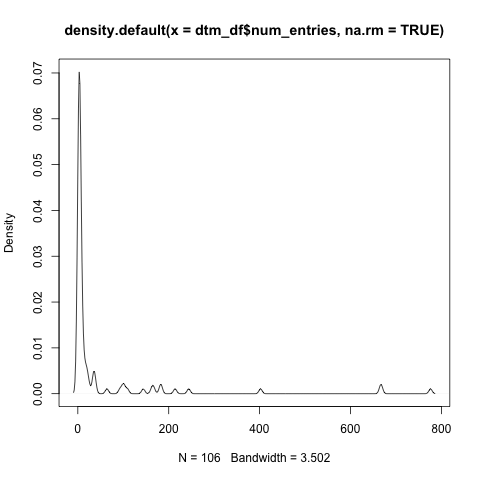

In [10]:
%%R

dtm_df$num_entries = rowSums(dtm_df[1:cols_to_sum])
dtm_df["num_occurances",] = colSums(dtm_df[1:rows_to_sum,])
dtm_df["num_occurances","num_entries"] = NA 

plot(density(dtm_df$num_entries, na.rm = TRUE))
table(dtm_df$num_entries, useNA = "ifany") #number of documents with each number of entries

print(paste("There are", length(which(dtm_df$num_entries >= 10)), "documents with 10 or more entries."))
print(paste("There are", length(which(dtm_df$num_entries >= 100)), "documents with 100 or more entries."))

[1] "76.88% of entries appear only once or twice across the corpus"
[1] "25 entries occur in 10 or more documents"
[1] "including one that occurs 189 times across the 106 documents"
[1] "The most common entry is X.ŋeš.x.na.na"


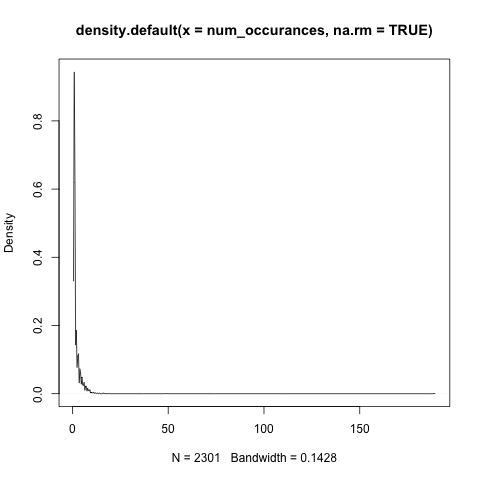

In [11]:
%%R 

num_occurances = unlist(dtm_df["num_occurances",])
plot(density(num_occurances, na.rm = TRUE))
table(num_occurances, useNA = "ifany")

rare = round(length(which(dtm_df["num_occurances",] <=2))/cols_to_sum*100,2)
common = length(which(dtm_df["num_occurances",] >=10))
most_common = max(dtm_df["num_occurances",], na.rm = TRUE)
most_common_entry = colnames(dtm_df[which(dtm_df["num_occurances",] == most_common)])

print(paste0(rare, "% of entries appear only once or twice across the corpus"))
print(paste(common, "entries occur in 10 or more documents"))
print(paste("including one that occurs", most_common, "times across the", rows_to_sum, "documents"))
print(paste("The most common entry is", most_common_entry))

In [12]:
%%R 
# Look at some of the most common entries
colnames(dtm_df)[which(dtm_df["num_occurances",] >= 10)]

 [1] "al.hoe.n"                      "allanum.oak.n"                
 [3] "dilim.spoon.n"                 "e.house.n_gigir.chariot.n"    
 [5] "ellag.ball.n"                  "gigir.chariot.n"              
 [7] "guza.chair.n_x.na.na"          "hašhur.apple.n"               
 [9] "hašhur.apple.n_kur.mountain.n" "kid.da.twig.n"                
[11] "kur.wood.n"                    "madal.pole.n"                 
[13] "peš.fig.n"                     "sugin.rot.n"                  
[15] "x.x.na.na"                     "x.na.na"                      
[17] "x.na.na_ŋešnimbar.palm.n"      "X.ŋeš.kal.na.na"              
[19] "X.ŋeš.x.x.x.na.na"             "X.ŋeš.x.x.na.na"              
[21] "X.ŋeš.x.na.na"                 "X.ŋeš.x.na.na_apin.plow.n"    
[23] "šagkal.tree.n"                 "šedug.tree.n"                 
[25] "šenu.tree.n"                  


In [13]:
%%R 

# currently "variables" (entries) are sorted alphabetically, would like sorted by frequency
dtm_df = as.matrix((dtm_df > 0) + 0) # Converts to binary presence/absence information
dtm_df = dtm_df[,order(colSums(dtm_df), decreasing = TRUE)]
dtm_df = as.data.frame(dtm_df)

In [14]:
%%R 

# Need to recaculate number of occurances, as was converted to binary. 
dtm_df$num_entries = rowSums(dtm_df[1:cols_to_sum])
dtm_df["num_occurances",] = colSums(dtm_df[1:rows_to_sum,])
dtm_df["num_occurances","num_entries"] = NA 

num_occurances = unlist(dtm_df["num_occurances",])
most_frequent = max(num_occurances, na.rm = TRUE)
most_frequent_entry = colnames(dtm_df[which(dtm_df["num_occurances",] == most_frequent)])

print(paste(table(num_occurances)[1], "entries appear in only one document"))
print(paste("The entry that appears in the most documents is", most_frequent_entry))

table(num_occurances, useNA = "ifany")


[1] "1547 entries appear in only one document"
[1] "The entry that appears in the most documents is X.ŋeš.x.na.na"
num_occurances
   1    2    3    4    5    6    7    8    9   10   11   12   21 <NA> 
1547  270  169  118   69   56   26   25    8    7    4    1    1    1 


In [15]:
%%R
# These entries appear in at least 10 different documents.
colnames(dtm_df)[which(dtm_df["num_occurances",] >=10)]

 [1] "X.ŋeš.x.na.na"                 "al.hoe.n"                     
 [3] "hašhur.apple.n"                "hašhur.apple.n_kur.mountain.n"
 [5] "peš.fig.n"                     "šedug.tree.n"                 
 [7] "allanum.oak.n"                 "dilim.spoon.n"                
 [9] "e.house.n_gigir.chariot.n"     "gigir.chariot.n"              
[11] "X.ŋeš.x.x.na.na"               "šagkal.tree.n"                
[13] "šenu.tree.n"                  


In [16]:
%%R
dtm_df$document = row.names(dtm_df) #add document names as row names
dtm_df = dtm_df[-which(row.names(dtm_df) == "num_occurances"),] # remove num_occurances row

In [17]:
%%R

#install.packages("reshape")
library(reshape)

melted_dtm_df = melt(dtm_df)
head(melted_dtm_df)

//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Using document as id variables

  warnings.warn(x, RRuntimeWarning)


  document      variable value
1  P117395 X.ŋeš.x.na.na     0
2  P117404 X.ŋeš.x.na.na     0
3  P128345 X.ŋeš.x.na.na     0
4  P224980 X.ŋeš.x.na.na     0
5  P224986 X.ŋeš.x.na.na     0
6  P224994 X.ŋeš.x.na.na     0


In [18]:
%%R 
# http://stackoverflow.com/questions/10397183/heat-map-of-binary-data-using-r-or-python
#install.packages("ggplot2")
library(ggplot2)
# ggplot(data = melted_dtm_df[150000:160474,], aes(y=document, x=variable, fill=value)) + 
#   geom_tile() +
#   theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 5))

#qplot(data=melted_dtm_df, x=variable,y=document, fill=factor(value),
#    geom="tile")+scale_fill_manual(values=c("0"="lightblue", "1"="red")) +
#  theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 1), axis.text.y = element_text(size = 3))

# Look at a subset
# qplot(data = melted_dtm_df[1:10000,], x=variable, y=document, fill=factor(value),
#     geom="tile")+scale_fill_manual(values=c("0"="lightblue", "1"="red")) +
# theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 8), axis.text.y = element_text(size = 5))


# Grouping Documents by Entry Similarity  
We can use hierarchical clustering with our presence/absence matrix to uncover groups of similar documents. Ideally, we can benchmark these clusters' accuracy in uncovering geographically or chronologically related documents by looking at metadata, but for this collection the metadata may be too sparse to do that benchmarking.  

In either case, we can establish a workflow for doing hierarchical clustering and apply that to other datasets with better provenance information to test for cluster utility.  

Troubleshooting note:  
When running R as a magic within Jupyter notebook, running install.packages() leads to the notebook prompting you for a selection. It turns out that this is due to the fact that anaconda actually installs a second R installation and stores installed packages separately from the users "main" R installation.  

To avoid this issue, run '.libPaths()' within R in your console to find the path where anaconda stores your packages. You can then download binaries from CRAN and put them in that directory. 

In [19]:
# %%R 
# See Troubleshooting note above

#install.packages("ggdendro")
# install.packages("ggdendro", "/anaconda/lib/R/library")

In [20]:
%%R
library(ggdendro)
clusters <- hclust(dist(dtm_df))

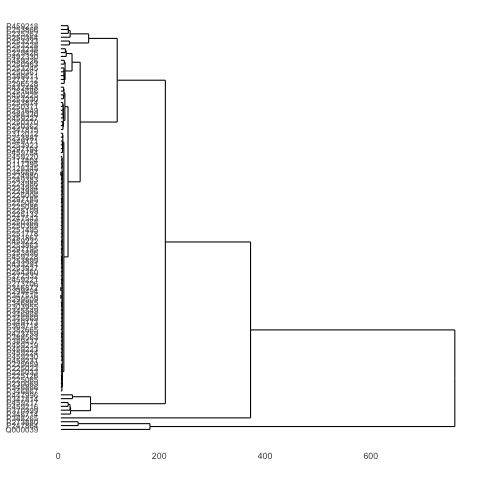

In [21]:
%%R
ggdendrogram(clusters, rotate = TRUE) + theme(axis.text.y = element_text(size = 8))

# Note By Niek on metadata
For the metadata it is better to use `data/metadata/dcclt-eta.csv` and select the relevant records by `id_text`. This is because the notebook `metadata.ipynb` can recreate that file when corrections have been made and because in the future we may be working with a larger selection of texts.

In [22]:
%%R 
# Bring in metadata
ids = read.csv("../data/metadata/dcclt_meta.csv")
ids$document = ids$X
ids$X = NULL
head(ids)

  designation   period provenience document
1   W 06435,a Uruk III        Uruk  P000001
2   W 06435,b Uruk III        Uruk  P000002
3   W 09123,d  Uruk IV        Uruk  P000003
4   W 09169,d  Uruk IV        Uruk  P000004
5   W 09206,k  Uruk IV        Uruk  P000005
6  W 09656,h1  Uruk IV        Uruk  P000006


In [89]:
%%R
# Add provenance information to dtm_df
dtm_df = merge(dtm_df, ids, by = "document")
dtm_df$provenience = droplevels(dtm_df)$provenience
table(dtm_df$provenience)


       Isin        Kish    Nerebtum      Nippur not entered   Shaduppum 
         10           1           1           2          27           1 
  uncertain     unclear          Ur        Uruk 
         38          16           8           2 


 [1] "Isin"        "Kish"        "Nerebtum"    "Nippur"      "not entered"
 [6] "Shaduppum"   "uncertain"   "unclear"     "Ur"          "Uruk"       


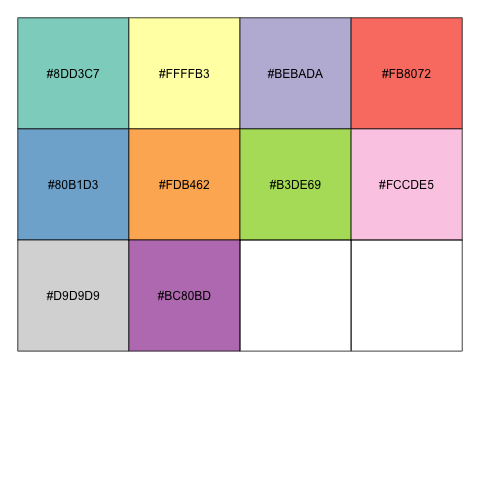

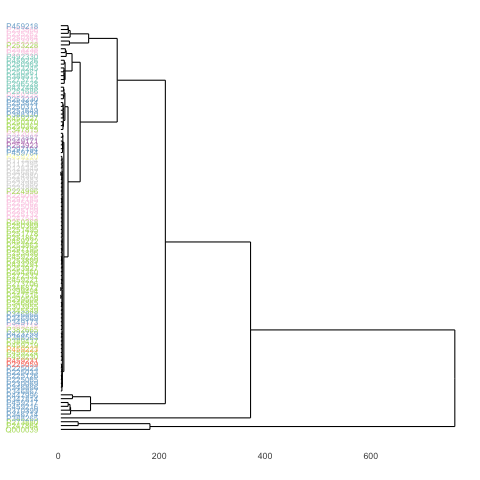

In [114]:
%%R

# Add colors to dendrogram by provenance
library(scales)
numColors = length(levels(factor(dtm_df$provenience)))
numColors
myPalette = brewer_pal(palette = "Set3")(numColors)
names(myPalette) = levels(dtm_df$provenience)
print(names(myPalette))
show_col(myPalette)
ggdendrogram(clusters, rotate = TRUE) + theme(axis.text.y = element_text(size = 8, color = myPalette[dtm_df$provenience]))
